# Final Project: Image classifier for the Brain Tumor Dataset

Our goal is to be able to classify if the image of the brain MRI has a brain tumor or not.

In [1]:
import tensorflow as tf
# check the version
tf.__version__

'2.5.0'

In [2]:
import tensorflow as tf
from scipy.io import loadmat

In [3]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Conv2D, MaxPooling2D 
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# import
import numpy as np

import matplotlib.pyplot as plt
import h5py 
import scipy
from PIL import Image
from scipy import ndimage
#from lr_utils import load_dataset
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline

## 1. Load and preprocess the dataset


In [7]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
##copy and paste the lr_utils.py into here to simplify things.

    
def loadDataset():
    train_dataset = h5py.File('gdrive/My Drive/AML - Project/final_file.hdf5', "r")
    train_set_x_orig = np.array(train_dataset["train_img"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_labels"][:]) # your train set labels

    test_dataset = h5py.File('gdrive/My Drive/AML - Project/final_file.hdf5', "r")
    test_set_x_orig = np.array(test_dataset["test_img"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_labels"][:]) # your test set labels
    
    #Also load in the cross validation set 
    cv_dataset = h5py.File('gdrive/My Drive/AML - Project/final_file.hdf5', "r")
    cv_set_x_orig = np.array(cv_dataset["cv_img"][:]) # your test set features
    cv_set_y_orig = np.array(cv_dataset["cv_labels"][:]) # your test set labels

   # classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    cv_set_y_orig = cv_set_y_orig.reshape((1, cv_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, cv_set_x_orig, cv_set_y_orig

In [13]:
# Loading the data 
train_X, train_y, test_X, test_y, cv_X, cv_y= loadDataset()
print(train_X)

[[[[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  ...

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]

  [[  0   0   0]
   [  0   0   0]
   [  0   0   0]
   ...
   [  0   0   0]
   [  0   0   0]
   [  0   0   0]]]


 [[[  1   1   1]
   [  1   1   1]
   [  1   1   1]
   ...
   [  1   1   1]
   [  1   1   1]
   [  1   1   1]]

  [[  1   1   1]
   [  1   1   1]
   [  1   1   1]
   ...
   [  1   1   1]
   [  1   1   1]
   [  1   1   1]]

  [[  1   1   1]
   [  1   1   1]
   [  1   1   1]
   ...
   [ 83  83  83]
   [243 243 243]
   [  2   2

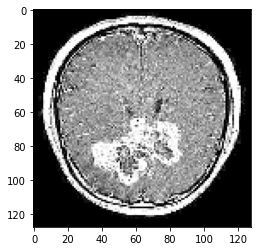

In [14]:
# Example of a picture
index = 24
plt.imshow(train_X[index])
#print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")
#Feel free also to change the index value and re-run to see other images.

In [15]:
# Find the values below:
m_train = train_X.shape[0]
m_test = test_X.shape[0]
num_px = test_X.shape[1]
m_cv =    cv_X.shape[0]

##fix the y dimensions
train_y = train_y.T
test_y = test_y.T
cv_y = cv_y.T

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_X shape: " + str(train_X.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_X shape: " + str(test_X.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: m_train = 1800
Number of testing examples: m_test = 600
Height/Width of each image: num_px = 128
Each image is of size: (128, 128, 3)
train_X shape: (1800, 128, 128, 3)
train_y shape: (1800, 1)
test_X shape: (600, 128, 128, 3)
test_y shape: (600, 1)


In [16]:
# Rescale the image values so that they lie in between 0 and 1.

train_X = train_X / 255.
test_X = test_X / 255.
cv_X = cv_X / 255.

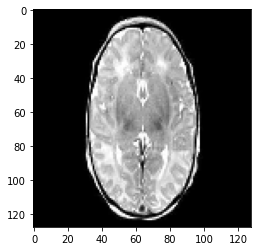

label: [0]


In [17]:
# Display one of the images

i = 0
img = train_X[i, : , :]
plt.imshow(img)
plt.show()
print(f"label: {train_y[i]}")

#Modeling

In [18]:
# build the model
# the input layer with input_shape (28, 28)
# one hidden layer, with 64 units, with a relu activation function.
# the output layer has 1 unit and uses sigmoid activation because we have binary classification.

model = Sequential([
                    Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Conv2D(filters=6, kernel_size=(5,5), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu'),
                    Dense(1, activation='sigmoid')
])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 6)       456       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 58, 6)         906       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 6)         0         
_________________________________________________________________
flatten (Flatten)            (None, 5046)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                323008    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [20]:
# compile the model for binary classfiication. We want to use both recall and the accuracy to 
#evaluate our model. Recall is especially important because a false negative may cost someone's life,
#if we tell them that they don't have a tumor but they actually do have one.
opt = tf.keras.optimizers.Adam(learning_rate = 0.005)
#recall = tf.keras.metrics.Recall()
model.compile(
    optimizer = opt,
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.Recall(), 'binary_accuracy']
)




In [21]:
#define checkpoint
checkpoint_best_path = 'model_checkpoints_best/checkpoint'
checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path,
                             save_freq='epoch',
                             save_weights_only=True,
                             monitor='val_recall_14',
                             save_best_only=True,
                             verbose=1)

In [22]:
# fit the model

history = model.fit(train_X, train_y, epochs = 5, batch_size = 64, verbose = 2, validation_data = (cv_X, cv_y), callbacks = [checkpoint_best])
# epochs = 8: training will make 8 complete passes through the dataset.
# batch_size = 256: By default, the batch size is set to 32.
# verbose = 2: print only one line per epoch
# verbose = 1 (or True): print everything (the defalut)
# verbose = 0 (or False): silence the print out


Epoch 1/5
29/29 - 26s - loss: 0.6720 - recall: 0.7349 - binary_accuracy: 0.6844 - val_loss: 0.4927 - val_recall: 0.8404 - val_binary_accuracy: 0.7700
Epoch 2/5
29/29 - 25s - loss: 0.4449 - recall: 0.8565 - binary_accuracy: 0.7972 - val_loss: 0.3422 - val_recall: 0.7850 - val_binary_accuracy: 0.8550
Epoch 3/5
29/29 - 25s - loss: 0.2638 - recall: 0.9069 - binary_accuracy: 0.8933 - val_loss: 0.1790 - val_recall: 0.9577 - val_binary_accuracy: 0.9383
Epoch 4/5
29/29 - 25s - loss: 0.1391 - recall: 0.9529 - binary_accuracy: 0.9478 - val_loss: 0.1591 - val_recall: 0.9837 - val_binary_accuracy: 0.9400
Epoch 5/5
29/29 - 26s - loss: 0.0828 - recall: 0.9759 - binary_accuracy: 0.9711 - val_loss: 0.1090 - val_recall: 0.9674 - val_binary_accuracy: 0.9617


In [23]:
# Load the history into a pandas Dataframe

df = pd.DataFrame(history.history)
df.head()

,loss,recall,binary_accuracy,val_loss,val_recall,val_binary_accuracy
0,0.671985,0.734940,0.684444,0.492675,0.840391,0.770000
1,0.444934,0.856517,0.797222,0.342208,0.785016,0.855000
2,0.263780,0.906900,0.893333,0.178977,0.957655,0.938333
3,0.139092,0.952902,0.947778,0.159095,0.983713,0.940000
4,0.082840,0.975904,0.971111,0.108969,0.967427,0.961667


#A Note
Our recalls and accuracys are very high, but this is to be expected because the tumor in the MRI picture of the brain is extremely visible.

In [24]:
! ls -lh model_checkpoints_best

ls: cannot access 'model_checkpoints_best': No such file or directory


[Text(0, 0.5, 'Loss'), Text(0.5, 0, 'Epochs')]

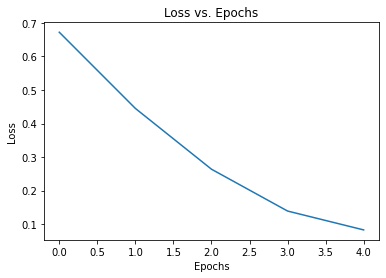

In [25]:
# Make a plot for the training loss

loss_plot = df.plot(y="loss", title = "Loss vs. Epochs", legend=False)
loss_plot.set(xlabel="Epochs", ylabel="Loss")

[Text(0, 0.5, 'Validation Loss'), Text(0.5, 0, 'Epochs')]

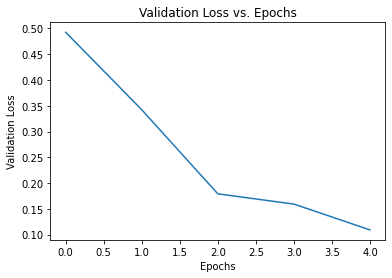

In [26]:
# Make a plot for the validation loss

loss_plot = df.plot(y="val_loss", title = "Validation Loss vs. Epochs", legend=False)
loss_plot.set(xlabel="Epochs", ylabel="Validation Loss")

[Text(0, 0.5, 'binary_accuracy'), Text(0.5, 0, 'Epochs')]

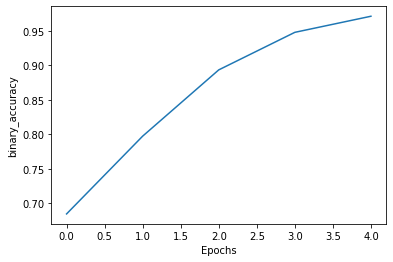

In [27]:
# Make a plot for the training binary accuracy

accuracy_plot = df.plot(y="binary_accuracy", legend=False)
accuracy_plot.set(xlabel="Epochs", ylabel="binary_accuracy")

[Text(0, 0.5, 'Validation binary_accuracy'), Text(0.5, 0, 'Epochs')]

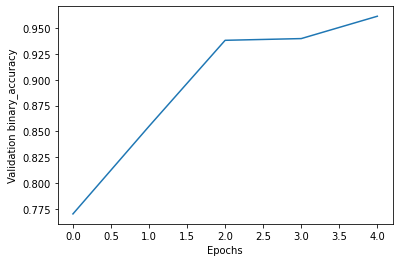

In [28]:
# Make a plot for the validation binary accuracy

accuracy_plot = df.plot(y="val_binary_accuracy", legend=False)
accuracy_plot.set(xlabel="Epochs", ylabel="Validation binary_accuracy")

In [29]:
# Make a plot for the training recall

accuracy_plot = df.plot(y="recall_12", legend=False)
accuracy_plot.set(xlabel="Epochs", ylabel="training recall")

KeyError: ignored

In [ ]:
# Make a plot for the val recall

accuracy_plot = df.plot(y='val_recall_12', legend=False)
accuracy_plot.set(xlabel="Epochs", ylabel="val recall")

In [ ]:
test_loss, test_accuracy, recall = model.evaluate(test_X, test_y)

Model1

In [ ]:

cnn_model1 = Sequential([
                   Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Conv2D(filters=6, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Flatten(),
                    Dense(120, activation = 'relu'),
                    Dense(84, activation = 'relu'),
                    Dense(1, activation='sigmoid')
])

cnn_model1.summary()

opt1 = tf.keras.optimizers.Adam(learning_rate = 0.005)
cnn_model1.compile(
    optimizer = opt1,
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.Recall(), 'binary_accuracy']
)


cnn_checkpoint_path1 = 'model_checkpoints/checkpoint1'
cnn_checkpoint1 = ModelCheckpoint(filepath=cnn_checkpoint_path1,
                             save_freq='epoch',
                             save_weights_only=True,
                             save_best_only=True,
                             verbose=1)

history1 = cnn_model1.fit(train_X, train_y, epochs = 5, batch_size = 64, verbose = 2, validation_data = (cv_X, cv_y), callbacks = [cnn_checkpoint1])

# Plot the training and validation accuracy with epoch
plt.plot(history1.history['binary_accuracy'])
plt.plot(history1.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Plot the training and validation loss

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

df1 = pd.DataFrame(history1.history)
df1.head()

test_loss1, test_accuracy1, recall = cnn_model1.evaluate(test_X, test_y)

In [ ]:
df1.head()

MODEL2

In [ ]:
cnn_model2 = Sequential([
                   Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Conv2D(filters=6, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Conv2D(filters=6, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Flatten(),
                    Dense(120, activation = 'relu'),
                    Dense(84, activation = 'relu'),
                    Dense(1, activation='sigmoid')
])

cnn_model2.summary()

# compile the model for binary classfiication. We want to use both recall and the accuracy to 
#evaluate our model. Recall is especially important because a false negative may cost someone's life,
#if we tell them that they don't have a tumor but they actually do have one.
opt2 = tf.keras.optimizers.Adam(learning_rate = 0.005)
#recall = tf.keras.metrics.Recall()
cnn_model2.compile(
    optimizer = opt2,
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.Recall(), 'binary_accuracy']
)


cnn_checkpoint_path2 = 'model_checkpoints/checkpoint2'
cnn_checkpoint2 = ModelCheckpoint(filepath=cnn_checkpoint_path2,
                             save_freq='epoch',
                             save_weights_only=True,
                             save_best_only=True,
                             verbose=1)


history2 = cnn_model2.fit(train_X, train_y, epochs = 5, batch_size = 64, verbose = 2, validation_data = (cv_X, cv_y), callbacks = [cnn_checkpoint2])

# Plot the training and validation accuracy with epoch
plt.plot(history2.history['binary_accuracy'])
plt.plot(history2.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Plot the training and validation loss

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

test_loss2, test_accuracy2, recall = cnn_model2.evaluate(test_X, test_y)

df2 = pd.DataFrame(history2.history)
df2.head()

Model3

In [ ]:
cnn_model3 = Sequential([
                   Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Conv2D(filters=6, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Flatten(),
                    Dense(160, activation = 'relu'),
                    Dense(120, activation = 'relu'),
                    Dense(1, activation='sigmoid')
])

cnn_model3.summary()

# compile the model for binary classfiication. We want to use both recall and the accuracy to 
#evaluate our model. Recall is especially important because a false negative may cost someone's life,
#if we tell them that they don't have a tumor but they actually do have one.
opt3 = tf.keras.optimizers.Adam(learning_rate = 0.005)
#recall = tf.keras.metrics.Recall()
cnn_model3.compile(
    optimizer = opt3,
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.Recall(), 'binary_accuracy']
)


cnn_checkpoint_path3 = 'model_checkpoints/checkpoint3'
cnn_checkpoint3 = ModelCheckpoint(filepath=cnn_checkpoint_path3,
                             save_freq='epoch',
                             save_weights_only=True,
                             save_best_only=True,
                             verbose=1)


history3 = cnn_model3.fit(train_X, train_y, epochs = 5, batch_size = 64, verbose = 2, validation_data = (cv_X, cv_y), callbacks = [cnn_checkpoint3])


# Plot the training and validation accuracy with epoch
plt.plot(history3.history['binary_accuracy'])
plt.plot(history3.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Plot the training and validation loss

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

test_loss3, test_accuracy3, recall = cnn_model3.evaluate(test_X, test_y)

df3 = pd.DataFrame(history3.history)
df3.head()

Model4

In [ ]:
cnn_model4 = Sequential([
                   Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Conv2D(filters=6, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Flatten(),
                    Dense(84, activation = 'relu'),
                    Dense(56, activation = 'relu'),
                    Dense(1, activation='sigmoid')
])

cnn_model4.summary()

# compile the model for binary classfiication. We want to use both recall and the accuracy to 
#evaluate our model. Recall is especially important because a false negative may cost someone's life,
#if we tell them that they don't have a tumor but they actually do have one.
opt4 = tf.keras.optimizers.Adam(learning_rate = 0.005)
#recall = tf.keras.metrics.Recall()
cnn_model4.compile(
    optimizer = opt4,
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.Recall(), 'binary_accuracy']
)


cnn_checkpoint_path4 = 'model_checkpoints/checkpoint4'
cnn_checkpoint4 = ModelCheckpoint(filepath=cnn_checkpoint_path4,
                             save_freq='epoch',
                             save_weights_only=True,
                             save_best_only=True,
                             verbose=1)


history4 = cnn_model4.fit(train_X, train_y, epochs = 5, batch_size = 64, verbose = 2, validation_data = (cv_X, cv_y), callbacks = [cnn_checkpoint4])


# Plot the training and validation accuracy with epoch
plt.plot(history4.history['binary_accuracy'])
plt.plot(history4.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Plot the training and validation loss

plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


test_loss4, test_accuracy4, recall = cnn_model4.evaluate(test_X, test_y)

df4 = pd.DataFrame(history4.history)
df4.head()

Model5

In [ ]:
cnn_model5 = Sequential([
                   Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Conv2D(filters=6, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu'),
                    Dense(36, activation = 'relu'),
                    Dense(1, activation='sigmoid')
])

cnn_model5.summary()

# compile the model for binary classfiication. We want to use both recall and the accuracy to 
#evaluate our model. Recall is especially important because a false negative may cost someone's life,
#if we tell them that they don't have a tumor but they actually do have one.
opt5 = tf.keras.optimizers.Adam(learning_rate = 0.005)
#recall = tf.keras.metrics.Recall()
cnn_model5.compile(
    optimizer = opt5,
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.Recall(), 'binary_accuracy']
)


cnn_checkpoint_path5 = 'model_checkpoints/checkpoint5'
cnn_checkpoint5 = ModelCheckpoint(filepath=cnn_checkpoint_path5,
                             save_freq='epoch',
                             save_weights_only=True,
                             save_best_only=True,
                             verbose=1)


history5 = cnn_model5.fit(train_X, train_y, epochs = 5, batch_size = 64, verbose = 2, validation_data = (cv_X, cv_y), callbacks = [cnn_checkpoint5])


# Plot the training and validation accuracy with epoch
plt.plot(history5.history['binary_accuracy'])
plt.plot(history5.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Plot the training and validation loss

plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


test_loss5, test_accuracy5, recall = cnn_model5.evaluate(test_X, test_y)

df5 = pd.DataFrame(history5.history)
df5.head()

Model6

In [ ]:
cnn_model6 = Sequential([
                   Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Conv2D(filters=4, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu'),
                    Dense(36, activation = 'relu'),
                    Dense(1, activation='sigmoid')
])

cnn_model6.summary()

# compile the model for binary classfiication. We want to use both recall and the accuracy to 
#evaluate our model. Recall is especially important because a false negative may cost someone's life,
#if we tell them that they don't have a tumor but they actually do have one.
opt6 = tf.keras.optimizers.Adam(learning_rate = 0.005)
#recall = tf.keras.metrics.Recall()
cnn_model6.compile(
    optimizer = opt6,
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.Recall(), 'binary_accuracy']
)


cnn_checkpoint_path6 = 'model_checkpoints/checkpoint6'
cnn_checkpoint6 = ModelCheckpoint(filepath=cnn_checkpoint_path6,
                             save_freq='epoch',
                             save_weights_only=True,
                             save_best_only=True,
                             verbose=1)


history6 = cnn_model6.fit(train_X, train_y, epochs = 5, batch_size = 64, verbose = 2, validation_data = (cv_X, cv_y), callbacks = [cnn_checkpoint6])


# Plot the training and validation accuracy with epoch
plt.plot(history6.history['binary_accuracy'])
plt.plot(history6.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Plot the training and validation loss

plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


test_loss6, test_accuracy6, recall = cnn_model6.evaluate(test_X, test_y)

df6 = pd.DataFrame(history6.history)
df6.head()

Model7

In [ ]:
cnn_model7 = Sequential([
                   Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Conv2D(filters=4, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Conv2D(filters=4, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Flatten(),
                    Dense(84, activation = 'relu'),
                    Dense(64, activation = 'relu'),
                    Dense(36, activation = 'relu'),
                    Dense(28, activation = 'relu'),
                    Dense(1, activation='sigmoid')
])

cnn_model7.summary()

# compile the model for binary classfiication. We want to use both recall and the accuracy to 
#evaluate our model. Recall is especially important because a false negative may cost someone's life,
#if we tell them that they don't have a tumor but they actually do have one.
opt7 = tf.keras.optimizers.Adam(learning_rate = 0.005)
#recall = tf.keras.metrics.Recall()
cnn_model7.compile(
    optimizer = opt7,
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.Recall(), 'binary_accuracy']
)


cnn_checkpoint_path7 = 'model_checkpoints/checkpoint7'
cnn_checkpoint7 = ModelCheckpoint(filepath=cnn_checkpoint_path7,
                             save_freq='epoch',
                             save_weights_only=True,
                             save_best_only=True,
                             verbose=1)


history7 = cnn_model7.fit(train_X, train_y, epochs = 5, batch_size = 64, verbose = 2, validation_data = (cv_X, cv_y), callbacks = [cnn_checkpoint7])


# Plot the training and validation accuracy with epoch
plt.plot(history7.history['binary_accuracy'])
plt.plot(history7.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Plot the training and validation loss

plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


test_loss7, test_accuracy7, recall = cnn_model7.evaluate(test_X, test_y)

df7 = pd.DataFrame(history7.history)
df7.head()

Model8

In [ ]:
cnn_model8 = Sequential([
                   Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Conv2D(filters=4, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Conv2D(filters=4, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Flatten(),
                    Dense(128, activation = 'relu'),
                    Dense(84, activation = 'relu'),
                    Dense(68, activation = 'relu'),
                    Dense(10, activation = 'relu'),
                    Dense(1, activation='sigmoid')
])

cnn_model8.summary()

# compile the model for binary classfiication. We want to use both recall and the accuracy to 
#evaluate our model. Recall is especially important because a false negative may cost someone's life,
#if we tell them that they don't have a tumor but they actually do have one.
opt8 = tf.keras.optimizers.Adam(learning_rate = 0.005)
#recall = tf.keras.metrics.Recall()
cnn_model8.compile(
    optimizer = opt8,
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.Recall(), 'binary_accuracy']
)


cnn_checkpoint_path8 = 'model_checkpoints/checkpoint8'
cnn_checkpoint8 = ModelCheckpoint(filepath=cnn_checkpoint_path8,
                             save_freq='epoch',
                             save_weights_only=True,
                             save_best_only=True,
                             verbose=1)


history8 = cnn_model8.fit(train_X, train_y, epochs = 5, batch_size = 64, verbose = 2, validation_data = (cv_X, cv_y), callbacks = [cnn_checkpoint8])


# Plot the training and validation accuracy with epoch
plt.plot(history8.history['binary_accuracy'])
plt.plot(history8.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Plot the training and validation loss

plt.plot(history8.history['loss'])
plt.plot(history8.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


test_loss8, test_accuracy8, recall = cnn_model8.evaluate(test_X, test_y)

df8 = pd.DataFrame(history8.history)
df8.head()

Model9

In [ ]:
cnn_model9 = Sequential([
                   Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Conv2D(filters=6, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Conv2D(filters=6, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                    Flatten(),
                    Dense(84, activation = 'relu'),
                    Dense(64, activation = 'relu'),
                    Dense(36, activation = 'relu'),
                    Dense(28, activation = 'relu'),
                    Dense(1, activation='sigmoid')
])

cnn_model9.summary()

# compile the model for binary classfiication. We want to use both recall and the accuracy to 
#evaluate our model. Recall is especially important because a false negative may cost someone's life,
#if we tell them that they don't have a tumor but they actually do have one.
opt9 = tf.keras.optimizers.Adam(learning_rate = 0.005)
#recall = tf.keras.metrics.Recall()
cnn_model9.compile(
    optimizer = opt9,
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.Recall(), 'binary_accuracy']
)


cnn_checkpoint_path9 = 'model_checkpoints/checkpoint9'
cnn_checkpoint9 = ModelCheckpoint(filepath=cnn_checkpoint_path9,
                             save_freq='epoch',
                             save_weights_only=True,
                             save_best_only=True,
                             verbose=1)


history9 = cnn_model9.fit(train_X, train_y, epochs = 5, batch_size = 64, verbose = 2, validation_data = (cv_X, cv_y), callbacks = [cnn_checkpoint9])


# Plot the training and validation accuracy with epoch
plt.plot(history9.history['binary_accuracy'])
plt.plot(history9.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Plot the training and validation loss

plt.plot(history9.history['loss'])
plt.plot(history9.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


test_loss9, test_accuracy9, recall = cnn_model9.evaluate(test_X, test_y)

df9 = pd.DataFrame(history9.history)
df9.head()

Model10

In [ ]:
cnn_model10 = Sequential([
                   Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Conv2D(filters=6, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                    Conv2D(filters=6, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                    Flatten(),
                    Dense(84, activation = 'relu'),
                    Dense(64, activation = 'relu'),
                    Dense(36, activation = 'relu'),
                    Dense(28, activation = 'relu'),
                    Dense(1, activation='sigmoid')
])

cnn_model10.summary()

# compile the model for binary classfiication. We want to use both recall and the accuracy to 
#evaluate our model. Recall is especially important because a false negative may cost someone's life,
#if we tell them that they don't have a tumor but they actually do have one.
opt10 = tf.keras.optimizers.Adam(learning_rate = 0.005)
#recall = tf.keras.metrics.Recall()
cnn_model10.compile(
    optimizer = opt10,
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.Recall(), 'binary_accuracy']
)


cnn_checkpoint_path10 = 'model_checkpoints/checkpoint10'
cnn_checkpoint10 = ModelCheckpoint(filepath=cnn_checkpoint_path10,
                             save_freq='epoch',
                             save_weights_only=True,
                             save_best_only=True,
                             verbose=1)


history10 = cnn_model10.fit(train_X, train_y, epochs = 5, batch_size = 64, verbose = 2, validation_data = (cv_X, cv_y), callbacks = [cnn_checkpoint10])


# Plot the training and validation accuracy with epoch
plt.plot(history10.history['binary_accuracy'])
plt.plot(history10.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Plot the training and validation loss

plt.plot(history10.history['loss'])
plt.plot(history10.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


test_loss10, test_accuracy10, recall = cnn_model10.evaluate(test_X, test_y)

df10 = pd.DataFrame(history10.history)
df10.head()

## **1d** : try 3 different optimization algorithm


(1) model 11 - SGD: Gradient descent(with momentum) optimizer




In [ ]:
cnn_model11 = Sequential([
                   Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Conv2D(filters=6, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu'),
                    Dense(36, activation = 'relu'),
                    Dense(1, activation='sigmoid')
])

cnn_model11.summary()

# compile the model for binary classfiication. We want to use both recall and the accuracy to 
#evaluate our model. Recall is especially important because a false negative may cost someone's life,
#if we tell them that they don't have a tumor but they actually do have one.
opt11 = tf.keras.optimizers.SGD(learning_rate = 0.005)
#recall = tf.keras.metrics.Recall()
cnn_model11.compile(
    optimizer = opt11,
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.Recall(), 'binary_accuracy']
)


cnn_checkpoint_path11 = 'model_checkpoints/checkpoint11'
cnn_checkpoint11 = ModelCheckpoint(filepath=cnn_checkpoint_path11,
                             save_freq='epoch',
                             save_weights_only=True,
                             save_best_only=True,
                             verbose=1)


history11 = cnn_model11.fit(train_X, train_y, epochs = 5, batch_size = 64, verbose = 2, validation_data = (cv_X, cv_y), callbacks = [cnn_checkpoint11])


# Plot the training and validation accuracy with epoch
plt.plot(history11.history['binary_accuracy'])
plt.plot(history11.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Plot the training and validation loss

plt.plot(history11.history['loss'])
plt.plot(history11.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


test_loss11, test_accuracy11, recall = cnn_model11.evaluate(test_X, test_y)

df11 = pd.DataFrame(history11.history)
df11.head()

(2)model 12 - Adamax: Optimizer that implements the Adamax algorithm.

In [ ]:
cnn_model12 = Sequential([
                   Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Conv2D(filters=6, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu'),
                    Dense(36, activation = 'relu'),
                    Dense(1, activation='sigmoid')
])


opt12 = tf.keras.optimizers.Adamax(learning_rate = 0.005)

cnn_model12.compile(
    optimizer = opt12,
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.Recall(), 'binary_accuracy']
)


cnn_checkpoint_path12 = 'model_checkpoints/checkpoint12'
cnn_checkpoint12 = ModelCheckpoint(filepath=cnn_checkpoint_path12,
                             save_freq='epoch',
                             save_weights_only=True,
                             save_best_only=True,
                             verbose=1)


history12 = cnn_model12.fit(train_X, train_y, epochs = 5, batch_size = 64, verbose = 2, validation_data = (cv_X, cv_y), callbacks = [cnn_checkpoint12])


# Plot the training and validation accuracy with epoch
plt.plot(history12.history['binary_accuracy'])
plt.plot(history12.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Plot the training and validation loss

plt.plot(history12.history['loss'])
plt.plot(history12.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


test_loss12, test_accuracy12, recall = cnn_model12.evaluate(test_X, test_y)

df12 = pd.DataFrame(history12.history)
df12.head()

(3)model 13 - Nadam: optimizer that implements the Nadam algorithm.

In [ ]:
cnn_model13 = Sequential([
                   Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Conv2D(filters=4, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu'),
                    Dense(36, activation = 'relu'),
                    Dense(1, activation='sigmoid')
])


opt13 = tf.keras.optimizers.Nadam(learning_rate = 0.005)

cnn_model13.compile(
    optimizer = opt13,
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.Recall(), 'binary_accuracy']
)


cnn_checkpoint_path13 = 'model_checkpoints/checkpoint13'
cnn_checkpoint13 = ModelCheckpoint(filepath=cnn_checkpoint_path13,
                             save_freq='epoch',
                             save_weights_only=True,
                             save_best_only=True,
                             verbose=1)


history13 = cnn_model13.fit(train_X, train_y, epochs = 5, batch_size = 64, verbose = 2, validation_data = (cv_X, cv_y), callbacks = [cnn_checkpoint13])


# Plot the training and validation accuracy with epoch
plt.plot(history13.history['binary_accuracy'])
plt.plot(history13.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Plot the training and validation loss

plt.plot(history13.history['loss'])
plt.plot(history13.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


test_loss13, test_accuracy13, recall = cnn_model13.evaluate(test_X, test_y)

df13 = pd.DataFrame(history13.history)
df13.head()

## **1e** : try 3 different epochs

model 14:  optimizer = Adam, epochs = 10

In [ ]:
cnn_model14 = Sequential([
                   Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Conv2D(filters=4, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu'),
                    Dense(36, activation = 'relu'),
                    Dense(1, activation='sigmoid')
])


opt14 = tf.keras.optimizers.Adam(learning_rate = 0.005)
#recall = tf.keras.metrics.Recall()
cnn_model14.compile(
    optimizer = opt14,
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.Recall(), 'binary_accuracy']
)


cnn_checkpoint_path14 = 'model_checkpoints/checkpoint14'
cnn_checkpoint14 = ModelCheckpoint(filepath=cnn_checkpoint_path14,
                             save_freq='epoch',
                             save_weights_only=True,
                             save_best_only=True,
                             verbose=1)


history14 = cnn_model14.fit(train_X, train_y, epochs = 10, batch_size = 64, verbose = 2, validation_data = (cv_X, cv_y), callbacks = [cnn_checkpoint14])


# Plot the training and validation accuracy with epoch
plt.plot(history14.history['binary_accuracy'])
plt.plot(history14.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Plot the training and validation loss

plt.plot(history14.history['loss'])
plt.plot(history14.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


test_loss14, test_accuracy14, recall = cnn_model14.evaluate(test_X, test_y)

df14 = pd.DataFrame(history14.history)
df14.head()

In [ ]:
df14

model 15:  optimizer = Adam, epochs = 15 (based on model 6)

In [ ]:
cnn_model15 = Sequential([
                   Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Conv2D(filters=4, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu'),
                    Dense(36, activation = 'relu'),
                    Dense(1, activation='sigmoid')
])


opt15 = tf.keras.optimizers.Adam(learning_rate = 0.005)
#recall = tf.keras.metrics.Recall()
cnn_model15.compile(
    optimizer = opt15,
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.Recall(), 'binary_accuracy']
)


cnn_checkpoint_path15 = 'model_checkpoints/checkpoint15'
cnn_checkpoint15 = ModelCheckpoint(filepath=cnn_checkpoint_path15,
                             save_freq='epoch',
                             save_weights_only=True,
                             save_best_only=True,
                             verbose=1)


history15 = cnn_model15.fit(train_X, train_y, epochs = 15, batch_size = 64, verbose = 2, validation_data = (cv_X, cv_y), callbacks = [cnn_checkpoint15])


# Plot the training and validation accuracy with epoch
plt.plot(history15.history['binary_accuracy'])
plt.plot(history15.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Plot the training and validation loss

plt.plot(history15.history['loss'])
plt.plot(history15.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


test_loss15, test_accuracy15, recall = cnn_model15.evaluate(test_X, test_y)

df15 = pd.DataFrame(history15.history)
df15

In [ ]:
df15

model 16: optimizer= adam, epochs = 10 (based on model 5)

In [ ]:
cnn_model16 = Sequential([
                   Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Conv2D(filters=6, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu'),
                    Dense(36, activation = 'relu'),
                    Dense(1, activation='sigmoid')
])

opt16 = tf.keras.optimizers.Adam(learning_rate = 0.005)
#recall = tf.keras.metrics.Recall()
cnn_model16.compile(
    optimizer = opt16,
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.Recall(), 'binary_accuracy']
)


cnn_checkpoint_path16 = 'model_checkpoints/checkpoint16'
cnn_checkpoint16 = ModelCheckpoint(filepath=cnn_checkpoint_path16,
                             save_freq='epoch',
                             save_weights_only=True,
                             save_best_only=True,
                             verbose=1)


history16 = cnn_model16.fit(train_X, train_y, epochs = 10, batch_size = 64, verbose = 2, validation_data = (cv_X, cv_y), callbacks = [cnn_checkpoint16])


# Plot the training and validation accuracy with epoch
plt.plot(history16.history['binary_accuracy'])
plt.plot(history16.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Plot the training and validation loss

plt.plot(history16.history['loss'])
plt.plot(history16.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


test_loss16, test_accuracy16, recall = cnn_model16.evaluate(test_X, test_y)

df16 = pd.DataFrame(history16.history)
df16

## **1f** : try 3 different weight initializations

model 17: weights initializer = he_uniform (based on model 15)

In [ ]:
cnn_model17 = Sequential([
                   Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Conv2D(filters=4, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',
                          kernel_initializer ='he_uniform', bias_initializer = 'ones'),
                    Dense(36, activation = 'relu'),
                    Dense(1, activation='sigmoid')
])


opt17 = tf.keras.optimizers.Adam(learning_rate = 0.005)
#recall = tf.keras.metrics.Recall()
cnn_model17.compile(
    optimizer = opt17,
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.Recall(), 'binary_accuracy']
)


cnn_checkpoint_path17 = 'model_checkpoints/checkpoint17'
cnn_checkpoint17 = ModelCheckpoint(filepath=cnn_checkpoint_path17,
                             save_freq='epoch',
                             save_weights_only=True,
                             save_best_only=True,
                             verbose=1)


history17 = cnn_model17.fit(train_X, train_y, epochs = 15, batch_size = 64, verbose = 2, validation_data = (cv_X, cv_y), callbacks = [cnn_checkpoint17])


# Plot the training and validation accuracy with epoch
plt.plot(history17.history['binary_accuracy'])
plt.plot(history17.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Plot the training and validation loss

plt.plot(history17.history['loss'])
plt.plot(history17.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


test_loss17, test_accuracy17, recall = cnn_model17.evaluate(test_X, test_y)

df17 = pd.DataFrame(history17.history)
df17

model 18: weight initializer = lecun_uniform (based on model 15)

In [ ]:
cnn_model18 = Sequential([
                   Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Conv2D(filters=4, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu',
                          kernel_initializer ='lecun_uniform', bias_initializer = 'ones'),
                    Dense(36, activation = 'relu'),
                    Dense(1, activation='sigmoid')
])


opt18 = tf.keras.optimizers.Adam(learning_rate = 0.005)
#recall = tf.keras.metrics.Recall()
cnn_model18.compile(
    optimizer = opt18,
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.Recall(), 'binary_accuracy']
)


cnn_checkpoint_path18 = 'model_checkpoints/checkpoint18'
cnn_checkpoint18 = ModelCheckpoint(filepath=cnn_checkpoint_path18,
                             save_freq='epoch',
                             save_weights_only=True,
                             save_best_only=True,
                             verbose=1)


history18 = cnn_model18.fit(train_X, train_y, epochs = 15, batch_size = 64, verbose = 2, validation_data = (cv_X, cv_y), callbacks = [cnn_checkpoint18])


# Plot the training and validation accuracy with epoch
plt.plot(history18.history['binary_accuracy'])
plt.plot(history18.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Plot the training and validation loss

plt.plot(history18.history['loss'])
plt.plot(history18.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


test_loss18, test_accuracy18, recall = cnn_model18.evaluate(test_X, test_y)

df18 = pd.DataFrame(history18.history)
df18

model 19: weight initializer= glorot_uniform (based on model 15)

In [ ]:
cnn_model19 = Sequential([
                   Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Conv2D(filters=4, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu', 
                          kernel_initializer ='glorot_uniform', bias_initializer = 'ones'),
                    Dense(36, activation = 'relu'),
                    Dense(1, activation='sigmoid')
])


opt19 = tf.keras.optimizers.Adam(learning_rate = 0.005)
#recall = tf.keras.metrics.Recall()
cnn_model19.compile(
    optimizer = opt19,
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.Recall(), 'binary_accuracy']
)


cnn_checkpoint_path19 = 'model_checkpoints/checkpoint19'
cnn_checkpoint19 = ModelCheckpoint(filepath=cnn_checkpoint_path19,
                             save_freq='epoch',
                             save_weights_only=True,
                             save_best_only=True,
                             verbose=1)


history19 = cnn_model19.fit(train_X, train_y, epochs = 15, batch_size = 64, verbose = 2, validation_data = (cv_X, cv_y), callbacks = [cnn_checkpoint19])


# Plot the training and validation accuracy with epoch
plt.plot(history19.history['binary_accuracy'])
plt.plot(history19.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Plot the training and validation loss

plt.plot(history19.history['loss'])
plt.plot(history19.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


test_loss19, test_accuracy19, recall = cnn_model19.evaluate(test_X, test_y)

df19 = pd.DataFrame(history19.history)
df19

## **1g** : explain which model is the best model fitting your training set? Use this model for the next part

# **Best model for fitting the training set: model 19**
(traininig set accuracy = 1.0)

##2b. Can you improve your validation performance using L2 regularization?


In [ ]:
L2 = [0.001, 0.003, 0.005, 0.007, 0.009]
for i in L2:
  cnn_model = Sequential([
                   Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Conv2D(filters=4, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(i),
                          kernel_initializer ='glorot_uniform', bias_initializer = 'ones'),
                    Dense(36, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(i)),
                    Dense(1, activation='sigmoid')
])


  cnn_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.Recall(), 'binary_accuracy'] 
)


  cnn_checkpoint_path_new= 'model_checkpoints/checkpoint_new'
  cnn_checkpoint_new = ModelCheckpoint(filepath=cnn_checkpoint_path_new,
                             save_freq='epoch',
                             save_weights_only=True,
                             save_best_only=True,
                             verbose=1)


  history = cnn_model.fit(train_X, train_y, epochs = 15, batch_size = 64, verbose = False, validation_data = (cv_X, cv_y), callbacks = [cnn_checkpoint_new])

  # Plot the training and validation accuracy with epoch
  plt.plot(history.history['binary_accuracy'])
  plt.plot(history.history['val_binary_accuracy'])
  plt.title('Accuracy vs. epochs')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper right')
  plt.show()

  # Plot the training and validation loss

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Loss vs. epochs')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper right')
  plt.show()


  test_loss, test_accuracy, recall = cnn_model.evaluate(test_X, test_y)

  df_new = pd.DataFrame(history.history)
  print(df_new)



Improving validation performance using dropout regularization.


In [ ]:
Dropout_list = [0.1, 0.3, 0.5, 0.7, 0.9]
for i in Dropout_list:
  cnn_model = Sequential([
                          Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                          MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                          Conv2D(filters=4, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                          MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                          Flatten(),
                          Dense(64, activation = 'relu', kernel_initializer ='glorot_uniform', bias_initializer = 'ones'),
                          Dropout(i),
                          Dense(36, activation = 'relu'),
                          Dropout(i),
                          Dense(1, activation='sigmoid')
])


  cnn_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.Recall(), 'binary_accuracy'] 
)


  cnn_checkpoint_path_new2 = 'model_checkpoints/checkpoint_new2'
  cnn_checkpoint_new2 = ModelCheckpoint(filepath=cnn_checkpoint_path_new2,
                             save_freq='epoch',
                             save_weights_only=True,
                             save_best_only=True,
                             verbose=1)


  history = cnn_model.fit(train_X, train_y, epochs = 15, batch_size = 64, verbose = False, validation_data = (cv_X, cv_y), callbacks = [cnn_checkpoint_new2])

  # Plot the training and validation accuracy with epoch
  plt.plot(history.history['binary_accuracy'])
  plt.plot(history.history['val_binary_accuracy'])
  plt.title('Accuracy vs. epochs')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper right')
  plt.show()

  # Plot the training and validation loss

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Loss vs. epochs')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper right')
  plt.show()

  test_loss, test_accuracy, recall = cnn_model.evaluate(test_X, test_y)

  df_new = pd.DataFrame(history.history)
  print(df_new)
  

Improving validation  performance  using  a  mixture  of  dropout regularization and L2 regularization.


In [ ]:
L2 = [0.001, 0.003, 0.005, 0.007, 0.009]
Dropout_list = [0.1, 0.3, 0.5, 0.7, 0.9]
for i in L2:
  for j in Dropout_list:
    cnn_model = Sequential([
                   Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Conv2D(filters=4, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                    Flatten(),
                    Dense(64, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(i),
                          kernel_initializer ='glorot_uniform', bias_initializer = 'ones'),
                    Dropout(j),
                    Dense(36, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(i)),
                    Dropout(j),
                    Dense(1, activation='sigmoid')
    ])

    cnn_model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
        loss = 'binary_crossentropy', 
        metrics = [tf.keras.metrics.Recall(), 'binary_accuracy'] 
    )


    cnn_checkpoint_path_new3 = 'model_checkpoints/checkpoint_new3'
    cnn_checkpoint_new3 = ModelCheckpoint(filepath=cnn_checkpoint_path_new3,
                                     save_freq='epoch',
                                     save_weights_only=True,
                                     save_best_only=True,
                                     verbose=1)


    history = cnn_model.fit(train_X, train_y, epochs = 15, batch_size = 64, verbose = 2, validation_data = (cv_X, cv_y), callbacks = [cnn_checkpoint_new3])

    # Plot the training and validation accuracy with epoch
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()

    # Plot the training and validation loss

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()


    test_loss, test_accuracy, recall = cnn_model.evaluate(test_X, test_y)

    df_new = pd.DataFrame(history.history)
    print(df_new)

    

Improving validation  performance  using  batch-normalization?
 

(one  model   with   default   TF   batch-normalization parameters and four models with customized parameters) 

In [ ]:
cnn_model_bn = Sequential([
                        Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                        MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                        Conv2D(filters=4, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                        MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                        Flatten(), Dense(64, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.003),
                                         kernel_initializer ='glorot_uniform', bias_initializer = 'ones'),
                        Dropout(0.1),
                        Dense(36, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.003)),
                        BatchNormalization(),
                        Dropout(0.1),
                        BatchNormalization(),
                        Dense(1, activation='sigmoid')])

cnn_model_bn.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.Recall(), 'binary_accuracy'] 
    )


cnn_checkpoint_path_bn = 'model_checkpoints/checkpoint_bn'
cnn_checkpoint_bn = ModelCheckpoint(filepath=cnn_checkpoint_path_bn,
                                      save_freq='epoch',
                                      save_weights_only=True,
                                      save_best_only=True,
                                      verbose=1)


history = cnn_model_bn.fit(train_X, train_y, epochs = 15, batch_size = 64, verbose = 2, validation_data = (cv_X, cv_y), 
                           callbacks = [cnn_checkpoint_bn])

# Plot the training and validation accuracy with epoch
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

    # Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


test_loss, test_accuracy, recall = cnn_model_bn.evaluate(test_X, test_y)

df_new = pd.DataFrame(history.history)
print(df_new)


momentum=0.95,epsilon=0.005

In [ ]:
cnn_model_bn1 = Sequential([
                        Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                        MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                        Conv2D(filters=4, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                        MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                        Flatten(), Dense(64, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.003),
                                         kernel_initializer ='glorot_uniform', bias_initializer = 'ones'),
                        Dropout(0.1),
                        Dense(36, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.003)),
                        BatchNormalization(momentum=0.95,epsilon=0.005),
                        Dropout(0.1),
                        BatchNormalization(momentum=0.95,epsilon=0.005),
                        Dense(1, activation='sigmoid')])

cnn_model_bn1.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.Recall(), 'binary_accuracy'] 
    )

cnn_checkpoint_path_bn1 = 'model_checkpoints/checkpoint_bn1'
cnn_checkpoint_bn1 = ModelCheckpoint(filepath=cnn_checkpoint_path_bn1,
                                      save_freq='epoch',
                                      save_weights_only=True,
                                      save_best_only=True,
                                      verbose=1)


history = cnn_model_bn1.fit(train_X, train_y, epochs = 15, batch_size = 64, verbose = 2, validation_data = (cv_X, cv_y), 
                            callbacks = [cnn_checkpoint_bn1])

# Plot the training and validation accuracy with epoch
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

    # Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


test_loss, test_accuracy, recall = cnn_model_bn1.evaluate(test_X, test_y)

df_new = pd.DataFrame(history.history)
print(df_new)


momentum=0.90,epsilon=0.01

In [ ]:
cnn_model_bn2 = Sequential([
                        Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                        MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                        Conv2D(filters=4, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                        MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                        Flatten(), Dense(64, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.003),
                                         kernel_initializer ='glorot_uniform', bias_initializer = 'ones'),
                        Dropout(0.1),
                        Dense(36, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.003)),
                        BatchNormalization(momentum=0.90,epsilon=0.01),
                        Dropout(0.1),
                        BatchNormalization(momentum=0.90,epsilon=0.01),
                        Dense(1, activation='sigmoid')])

cnn_model_bn2.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.Recall(), 'binary_accuracy'] 
    )

cnn_checkpoint_path_bn2 = 'model_checkpoints/checkpoint_bn2'
cnn_checkpoint_bn2 = ModelCheckpoint(filepath=cnn_checkpoint_path_bn2,
                                      save_freq='epoch',
                                      save_weights_only=True,
                                      save_best_only=True,
                                      verbose=1)


history = cnn_model_bn2.fit(train_X, train_y, epochs = 15, batch_size = 64, 
                            verbose = 2, validation_data = (cv_X, cv_y), 
                            callbacks = [cnn_checkpoint_bn2])

# Plot the training and validation accuracy with epoch
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

    # Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


test_loss, test_accuracy, recall = cnn_model_bn2.evaluate(test_X, test_y)

df_new = pd.DataFrame(history.history)
print(df_new)


momentum=0.85, epsilon=0.015



In [ ]:
cnn_model_bn3 = Sequential([
                        Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                        MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                        Conv2D(filters=4, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                        MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                        Flatten(), Dense(64, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.003),
                                         kernel_initializer ='glorot_uniform', bias_initializer = 'ones'),
                        Dropout(0.1),
                        Dense(36, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.003)),
                        BatchNormalization(momentum=0.85,epsilon=0.015),
                        Dropout(0.1),
                        BatchNormalization(momentum=0.85,epsilon=0.015),
                        Dense(1, activation='sigmoid')])

cnn_model_bn3.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.Recall(), 'binary_accuracy'] 
    )

cnn_checkpoint_path_bn3 = 'model_checkpoints/checkpoint_bn3'
cnn_checkpoint_bn3 = ModelCheckpoint(filepath=cnn_checkpoint_path_bn3,
                                      save_freq='epoch',
                                      save_weights_only=True,
                                      save_best_only=True,
                                      verbose=1)


history = cnn_model_bn3.fit(train_X, train_y, epochs = 15, batch_size = 64, 
                            verbose = 2, validation_data = (cv_X, cv_y), 
                            callbacks = [cnn_checkpoint_bn3])

# Plot the training and validation accuracy with epoch
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

    # Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


test_loss, test_accuracy, recall = cnn_model_bn3.evaluate(test_X, test_y)

df_new = pd.DataFrame(history.history)
print(df_new)


momentum=0.8,epsilon=0.02

In [ ]:
cnn_model_bn4 = Sequential([
                        Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                        MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                        Conv2D(filters=4, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                        MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                        Flatten(), Dense(64, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.003),
                                         kernel_initializer ='glorot_uniform', bias_initializer = 'ones'),
                        Dropout(0.1),
                        Dense(36, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.003)),
                        BatchNormalization(momentum=0.8,epsilon=0.02),
                        Dropout(0.1),
                        BatchNormalization(momentum=0.8,epsilon=0.02),
                        Dense(1, activation='sigmoid')])

cnn_model_bn4.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.Recall(), 'binary_accuracy'] 
    )

cnn_checkpoint_path_bn4 = 'model_checkpoints/checkpoint_bn4'
cnn_checkpoint_bn4 = ModelCheckpoint(filepath=cnn_checkpoint_path_bn4,
                                      save_freq='epoch',
                                      save_weights_only=True,
                                      save_best_only=True,
                                      verbose=1)


history = cnn_model_bn4.fit(train_X, train_y, epochs = 15, batch_size = 64, 
                            verbose = 2, validation_data = (cv_X, cv_y), 
                            callbacks = [cnn_checkpoint_bn4])

# Plot the training and validation accuracy with epoch
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

    # Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


test_loss, test_accuracy, recall = cnn_model_bn4.evaluate(test_X, test_y)

df_new = pd.DataFrame(history.history)
print(df_new)


Improving validation  performance  using  a  mixture  of  batch-normalization and dropout regularization



In [ ]:
cnn_model_bndo = Sequential([
                        Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                        MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                        Conv2D(filters=4, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                        MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                        Flatten(), Dense(64, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.003),
                                         kernel_initializer ='glorot_uniform', bias_initializer = 'ones'),
                        Dropout(0.1),
                        Dense(36, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.003)),
                        BatchNormalization(momentum=0.90,epsilon=0.01),
                        Dropout(0.1),
                        BatchNormalization(momentum=0.90,epsilon=0.01),
                        Dense(1, activation='sigmoid')])

cnn_model_bndo.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.Recall(), 'binary_accuracy'] 
    )

cnn_checkpoint_path_bndo = 'model_checkpoints/checkpoint_bndo'
cnn_checkpoint_bndo = ModelCheckpoint(filepath=cnn_checkpoint_path_bndo,
                                      save_freq='epoch',
                                      save_weights_only=True,
                                      save_best_only=True,
                                      verbose=1)


history = cnn_model_bndo.fit(train_X, train_y, epochs = 15, batch_size = 64, 
                            verbose = 2, validation_data = (cv_X, cv_y), 
                            callbacks = [cnn_checkpoint_bndo])

# Plot the training and validation accuracy with epoch
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

    # Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


test_loss, test_accuracy, recall = cnn_model_bndo.evaluate(test_X, test_y)

df_new = pd.DataFrame(history.history)
print(df_new)


2  
BatchNorm: momentum=0.96, epsilon=0.002  
DropRate: 0.08  

In [ ]:
cnn_model_bndo2 = Sequential([
                        Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                        MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                        Conv2D(filters=4, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                        MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                        Flatten(), Dense(64, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.003),
                                         kernel_initializer ='glorot_uniform', bias_initializer = 'ones'),
                        Dropout(0.08),
                        Dense(36, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.003)),
                        BatchNormalization(momentum=0.96,epsilon=0.002),
                        Dropout(0.08),
                        BatchNormalization(momentum=0.96,epsilon=0.002),
                        Dense(1, activation='sigmoid')])

cnn_model_bndo2.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.Recall(), 'binary_accuracy'] 
    )

cnn_checkpoint_path_bndo2 = 'model_checkpoints/checkpoint_bndo2'
cnn_checkpoint_bndo2 = ModelCheckpoint(filepath=cnn_checkpoint_path_bndo2,
                                      save_freq='epoch',
                                      save_weights_only=True,
                                      save_best_only=True,
                                      verbose=1)


history = cnn_model_bndo2.fit(train_X, train_y, epochs = 15, batch_size = 64, 
                            verbose = 2, validation_data = (cv_X, cv_y), 
                            callbacks = [cnn_checkpoint_bndo2])

# Plot the training and validation accuracy with epoch
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

    # Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


test_loss, test_accuracy, recall = cnn_model_bndo2.evaluate(test_X, test_y)

df_new = pd.DataFrame(history.history)
print(df_new)


3  
BatchNorm:momentum=0.92, epsilon=0.005  
DropRate: 0.06

In [ ]:
cnn_model_bndo3 = Sequential([
                        Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                        MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                        Conv2D(filters=4, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                        MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                        Flatten(), Dense(64, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.003),
                                         kernel_initializer ='glorot_uniform', bias_initializer = 'ones'),
                        Dropout(0.06),
                        Dense(36, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.003)),
                        BatchNormalization(momentum=0.92,epsilon=0.005),
                        Dropout(0.06),
                        BatchNormalization(momentum=0.92,epsilon=0.005),
                        Dense(1, activation='sigmoid')])

cnn_model_bndo3.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.Recall(), 'binary_accuracy'] 
    )

cnn_checkpoint_path_bndo3 = 'model_checkpoints/checkpoint_bndo3'
cnn_checkpoint_bndo3 = ModelCheckpoint(filepath=cnn_checkpoint_path_bndo3,
                                      save_freq='epoch',
                                      save_weights_only=True,
                                      save_best_only=True,
                                      verbose=1)


history = cnn_model_bndo3.fit(train_X, train_y, epochs = 15, batch_size = 64, 
                            verbose = 2, validation_data = (cv_X, cv_y), 
                            callbacks = [cnn_checkpoint_bndo3])

# Plot the training and validation accuracy with epoch
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

    # Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


test_loss, test_accuracy, recall = cnn_model_bndo3.evaluate(test_X, test_y)

df_new = pd.DataFrame(history.history)
print(df_new)


4  
BatchNorm: momentum=0.90, epsilon=0.006  
DropRate: 0.04  

In [ ]:
cnn_model_bndo4 = Sequential([
                        Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                        MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                        Conv2D(filters=4, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                        MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                        Flatten(), Dense(64, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.003),
                                         kernel_initializer ='glorot_uniform', bias_initializer = 'ones'),
                        Dropout(0.04),
                        Dense(36, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.003)),
                        BatchNormalization(momentum=0.90, epsilon=0.006),
                        Dropout(0.04),
                        BatchNormalization(momentum=0.90, epsilon=0.006),
                        Dense(1, activation='sigmoid')])

cnn_model_bndo4.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.Recall(), 'binary_accuracy'])

cnn_checkpoint_path_bndo4 = 'model_checkpoints/checkpoint_bndo4'
cnn_checkpoint_bndo4 = ModelCheckpoint(filepath=cnn_checkpoint_path_bndo4,
                                      save_freq='epoch',
                                      save_weights_only=True,
                                      save_best_only=True,
                                      verbose=1)

history = cnn_model_bndo4.fit(train_X, train_y, epochs = 15, batch_size = 64, 
                            verbose = 2, validation_data = (cv_X, cv_y), 
                            callbacks = [cnn_checkpoint_bndo4])

# Plot the training and validation accuracy with epoch
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

    # Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


test_loss, test_accuracy, recall = cnn_model_bndo4.evaluate(test_X, test_y)

df_new = pd.DataFrame(history.history)
print(df_new)


5  
BatchNorm: momentum=0.70, epsilon=0.1  
DropRate:0.3  

In [ ]:
cnn_model_bndo5 = Sequential([
                        Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                        MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                        Conv2D(filters=4, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                        MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                        Flatten(), Dense(64, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.003),
                                         kernel_initializer ='glorot_uniform', bias_initializer = 'ones'),
                        Dropout(0.3),
                        Dense(36, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.003)),
                        BatchNormalization(momentum=0.70, epsilon=0.1),
                        Dropout(0.3),
                        BatchNormalization(momentum=0.70, epsilon=0.1),
                        Dense(1, activation='sigmoid')])

cnn_model_bndo5.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.Recall(), 'binary_accuracy'])

cnn_checkpoint_path_bndo5 = 'model_checkpoints/checkpoint_bndo5'
cnn_checkpoint_bndo5 = ModelCheckpoint(filepath=cnn_checkpoint_path_bndo5,
                                      save_freq='epoch',
                                      save_weights_only=True,
                                      save_best_only=True,
                                      verbose=1)

history = cnn_model_bndo5.fit(train_X, train_y, epochs = 15, batch_size = 64, 
                            verbose = 2, validation_data = (cv_X, cv_y), 
                            callbacks = [cnn_checkpoint_bndo5])

# Plot the training and validation accuracy with epoch
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

    # Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


test_loss, test_accuracy, recall = cnn_model_bndo5.evaluate(test_X, test_y)

df_new = pd.DataFrame(history.history)
print(df_new)


  Improving validation  performance  using  a  mixture  of  batch-normalization  and  dropout  regularization  and  L2  regularization


1  
BatchNorm:
momentum=0.90,
epsilon=0.01  
DropRate: 0.1  
L2 𝝀: 0.001

In [ ]:
cnn_model_bndol = Sequential([
                        Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                        MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                        Conv2D(filters=4, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                        MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                        Flatten(), Dense(64, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                         kernel_initializer ='glorot_uniform', bias_initializer = 'ones'),
                        Dropout(0.1),
                        Dense(36, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                        BatchNormalization(momentum=0.90,epsilon=0.01),
                        Dropout(0.1),
                        BatchNormalization(momentum=0.90,epsilon=0.01),
                        Dense(1, activation='sigmoid')])

cnn_model_bndol.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.Recall(), 'binary_accuracy'] 
    )

cnn_checkpoint_path_bndol = 'model_checkpoints/checkpoint_bndol'
cnn_checkpoint_bndol = ModelCheckpoint(filepath=cnn_checkpoint_path_bndol,
                                      save_freq='epoch',
                                      save_weights_only=True,
                                      save_best_only=True,
                                      verbose=1)


history = cnn_model_bndol.fit(train_X, train_y, epochs = 15, batch_size = 64, 
                            verbose = 2, validation_data = (cv_X, cv_y), 
                            callbacks = [cnn_checkpoint_bndol])

# Plot the training and validation accuracy with epoch
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

    # Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


test_loss, test_accuracy, recall = cnn_model_bndol.evaluate(test_X, test_y)

df_new = pd.DataFrame(history.history)
print(df_new)


2  
BatchNorm:
momentum=0.96,
epsilon=0.002  
DropRate: 0.08  
L2 𝝀: 0.003

In [ ]:
cnn_model_bndol2 = Sequential([
                        Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                        MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                        Conv2D(filters=4, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                        MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                        Flatten(), Dense(64, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.003),
                                         kernel_initializer ='glorot_uniform', bias_initializer = 'ones'),
                        Dropout(0.08),
                        Dense(36, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.003)),
                        BatchNormalization(momentum=0.96, epsilon=0.002),
                        Dropout(0.08),
                        BatchNormalization(momentum=0.96, epsilon=0.002),
                        Dense(1, activation='sigmoid')])

cnn_model_bndol2.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.Recall(), 'binary_accuracy'])

cnn_checkpoint_path_bndol2 = 'model_checkpoints/checkpoint_bndol2'
cnn_checkpoint_bndol2 = ModelCheckpoint(filepath=cnn_checkpoint_path_bndol2,
                                      save_freq='epoch',
                                      save_weights_only=True,
                                      save_best_only=True,
                                      verbose=1)


history = cnn_model_bndol2.fit(train_X, train_y, epochs = 15, batch_size = 64, 
                            verbose = 2, validation_data = (cv_X, cv_y), 
                            callbacks = [cnn_checkpoint_bndol2])

# Plot the training and validation accuracy with epoch
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

    # Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


test_loss, test_accuracy, recall = cnn_model_bndol2.evaluate(test_X, test_y)

df_new = pd.DataFrame(history.history)
print(df_new)


3  
BatchNorm:
momentum=0.92,
epsilon=0.005  
DropRate: 0.06  
L2 𝝀: 0.005

In [ ]:
cnn_model_bndol3 = Sequential([
                        Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                        MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                        Conv2D(filters=4, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                        MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                        Flatten(), Dense(64, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.005),
                                         kernel_initializer ='glorot_uniform', bias_initializer = 'ones'),
                        Dropout(0.06),
                        Dense(36, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.005)),
                        BatchNormalization(momentum=0.92, epsilon=0.005),
                        Dropout(0.06),
                        BatchNormalization(momentum=0.92, epsilon=0.005),
                        Dense(1, activation='sigmoid')])

cnn_model_bndol3.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
    loss = 'binary_crossentropy', 
    metrics = [tf.keras.metrics.Recall(), 'binary_accuracy'])

cnn_checkpoint_path_bndol3 = 'model_checkpoints/checkpoint_bndol3'
cnn_checkpoint_bndol3 = ModelCheckpoint(filepath=cnn_checkpoint_path_bndol3,
                                      save_freq='epoch',
                                      save_weights_only=True,
                                      save_best_only=True,
                                      verbose=1)


history = cnn_model_bndol3.fit(train_X, train_y, epochs = 15, batch_size = 64, 
                            verbose = 2, validation_data = (cv_X, cv_y), 
                            callbacks = [cnn_checkpoint_bndol3])

# Plot the training and validation accuracy with epoch
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

    # Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


test_loss, test_accuracy, recall = cnn_model_bndol3.evaluate(test_X, test_y)

df_new = pd.DataFrame(history.history)
print(df_new)


4  
BatchNorm: momentum=0.90, epsilon=0.006  
DropRate: 0.04  
L2 𝝀: 0.007

In [ ]:
cnn_model_bndol4 = Sequential([
                        Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                        MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                        Conv2D(filters=4, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                        MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                        Flatten(), Dense(64, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.007),
                                         kernel_initializer ='glorot_uniform', bias_initializer = 'ones'),
                        Dropout(0.04),
                        Dense(36, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.007)),
                        BatchNormalization(momentum=0.90, epsilon=0.006),
                        Dropout(0.04),
                        BatchNormalization(momentum=0.90, epsilon=0.006),
                        Dense(1, activation='sigmoid')])

cnn_model_bndol4.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
    loss = 'binary_crossentropy', metrics = [tf.keras.metrics.Recall(), 'binary_accuracy'])

cnn_checkpoint_path_bndol4 = 'model_checkpoints/checkpoint_bndol4'
cnn_checkpoint_bndol4 = ModelCheckpoint(filepath=cnn_checkpoint_path_bndol4,
                                      save_freq='epoch', save_weights_only=True,
                                      save_best_only=True, verbose=1)

history = cnn_model_bndol4.fit(train_X, train_y, epochs = 15, batch_size = 64, verbose = 2, validation_data = (cv_X, cv_y), 
                            callbacks = [cnn_checkpoint_bndol4])

# Plot the training and validation accuracy with epoch
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

    # Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


test_loss, test_accuracy, recall = cnn_model_bndol4.evaluate(test_X, test_y)

df_new = pd.DataFrame(history.history)
print(df_new)


5  
BatchNorm: momentum=0.70, epsilon=0.1  
DropRate:0.3  
L2 𝝀: 0.009

In [ ]:
cnn_model_bndol5 = Sequential([
                        Conv2D(filters=6, kernel_size=(5,5), strides = (1,1),padding='valid', activation = 'relu', input_shape=(128,128,3)), # note we need 1 in  input_shape=(28,28,1)
                        MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                        Conv2D(filters=4, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'),
                        MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
                        Flatten(), Dense(64, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.009),
                                         kernel_initializer ='glorot_uniform', bias_initializer = 'ones'),
                        Dropout(0.3),
                        Dense(36, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.009)),
                        BatchNormalization(momentum=0.70, epsilon=0.1),
                        Dropout(0.3),
                        BatchNormalization(momentum=0.70, epsilon=0.1),
                        Dense(1, activation='sigmoid')])

cnn_model_bndol5.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
    loss = 'binary_crossentropy', metrics = [tf.keras.metrics.Recall(), 'binary_accuracy'])

cnn_checkpoint_path_bndol5 = 'model_checkpoints/checkpoint_bndol5'
cnn_checkpoint_bndol5 = ModelCheckpoint(filepath=cnn_checkpoint_path_bndol5,
                                      save_freq='epoch', save_weights_only=True,
                                      save_best_only=True, verbose=1)

history = cnn_model_bndol5.fit(train_X, train_y, epochs = 15, batch_size = 64, verbose = 2, validation_data = (cv_X, cv_y), 
                            callbacks = [cnn_checkpoint_bndol5])

# Plot the training and validation accuracy with epoch
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

    # Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


test_loss, test_accuracy, recall = cnn_model_bndol5.evaluate(test_X, test_y)

df_new = pd.DataFrame(history.history)
print(df_new)


While some models (like model 19) did provide a 100% accuracy and recall, there was visible 
Gap in the training and validation accuracies and loss among the two sets.  Whereas for model4
From part 2g it is a more stable fit, giving  us an accuracy and recall stable across train, validation
And the test set. We feel the dropout rate and L2 regularization with 0.90 momentum and
0.006 epsilon is removing some overfitting issues which were contributing towards 100% accuracy.

Overall, this model fit can be applied in real world scenarios without overfitting issues to 
Achieve consistent results.


